In [30]:
import os, sys, time, requests , signal
import numpy as np
import multiprocessing
import rasterio
import matplotlib
import hvsrpy
import pathlib
import pandas as pd
from matplotlib import pyplot as plt
from datetime import timedelta
from rasterio.transform import from_origin
from obspy import UTCDateTime, read_inventory
from obspy.clients.fdsn import Client
from obspy.signal import PPSD
from obspy.imaging.cm import pqlx
from obspy.signal.quality_control import MSEEDMetadata
from sqes_function import Calculation, Analysis, MySQLPool, Config
from datetime import datetime
# matplotlib.use('Agg')

### function list ###
# timeout handling function
def handle_timeout(signum,frame):
    raise TimeoutError

# processes rounding function
def processes_round(x, base=2):
    min_value = 4
    max_value = multiprocessing.cpu_count() // 3
    rounded_value = base * round(x / base)
    if rounded_value < min_value:
        return min_value
    elif rounded_value > max_value:
        return max_value
    else:
        return rounded_value
    
# create directory function
def create_directory(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
        print(f"{dir_path} created")
    else:
        print(f"{dir_path} exists")

def is_client_connected(client):
    try:
        # Try querying data to check connectivity
        client.get_events(starttime=UTCDateTime(2010,1,1,0,0,0), endtime=UTCDateTime(2010,1,2,0,1,0))
        return True
    except (requests.ConnectionError, requests.Timeout):
        return False

def get_location_info(st):
    location = []
    for tr in st:
        location.append(tr.stats.location)
    tmp = np.array(location)
    return np.unique(tmp)
    
# download data function
def DownloadData(client, sta, time0, time1, c):
    signal.signal(signal.SIGALRM, handle_timeout)
    signal.alarm(600)
    try:
        channel_codes = [f"SH{c}", f"BH{c}", f"HH{c}"] # [f"SH{c}", f"BH{c}", f"HH{c}"]
        for channel_code in channel_codes:
            network = "*" if channel_code == f"BH{c}" else "IA"
            try:
                st = client.get_waveforms(network, sta, "*", channel_code, time0, time1)
                if st.count() > 0:
                    st = st.merge(fill_value='interpolate')
                    if st.count() > 3:
                        loc_ = get_location_info(st)
                        st = st.select(location=loc_[0])
                    try:
                        inv = read_inventory(f"https://geof.bmkg.go.id/fdsnws/station/1/query?station={sta}&level=response&nodata=404")
                        return st, inv
                    except:
                        return st, None
            except:
                continue
    except TimeoutError:
        print(f"!! {sta} download timeout!")
        return "No Data", None
    # if all except
    return "No Data", None

def time_check(st):
	endt = min([st[0].stats.endtime, st[1].stats.endtime, st[2].stats.endtime])
	startt = max([st[0].stats.starttime, st[1].stats.starttime, st[2].stats.starttime])
	return endt, startt

def get_tif_values(src, lat, lon):
    keys = ["geology","vs30","photovoltaic"]

    values = {}
    for key, src in zip(keys,src):
        try:
            z = src.read()[0]
            idx = src.index(lon, lat) 
            # Read the value at the specified location 
            values[key] = float(z[idx])
        except Exception as e:
            print(e)
            values[key] = None
    return values

def plot_psd(psds,periods,NHNM,NLNM,outfile,sta,label):
    # Create a new figure and axis
    fig, ax = plt.subplots()
    
    # Plot the PSDs
    for i in range(len(psds)):
        ax.plot(periods[i], psds[i], linewidth=1, label=label[i])
    
    # Plot the NHNM and NLNM curves
    ax.plot(periods[i], NHNM, c='black', linewidth=2)
    ax.plot(periods[i], NLNM, c='black', linewidth=2)
    
    # Set axis to log scale
    ax.set_xscale('log')
    
    # Add grid, labels, and title
    ax.grid(True, which="both")
    ax.set_xlim((0.1, 100))
    ax.set_xlabel('Periods (s)')
    ax.set_ylabel(r'Power [$10\log_{10}(\frac{m^2/s^4}{Hz})$][dB]')
    ax.set_title(f"{sta} Station")
    
    # Add legend
    ax.legend(loc='upper right')
    
    # Save the figure
    fig.savefig(outfile)
    plt.close(fig)

def plot_hvsr(hvsr, hvsr_outfile):
    fig, ax = plt.subplots(figsize=(7,5))
    ax = hvsrpy.plot_single_panel_hvsr_curves(hvsr,ax=ax)
    ax.get_legend().remove()
    # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig.savefig(hvsr_outfile, bbox_inches='tight')
    # ax.set_xlabel("Frequency (Hz)")
    plt.close(fig)
    
def gval_to_geo(gval):
    if gval == 1:
        return "Sedimen Muda"
    elif gval == 2:
        return "Sedimen Periode Quarter"
    elif gval == 3:
        return "Batuan Gunung Api Muda"
    elif gval == 4:
        return "Batuan/Sedimen Tua Periode Tersier"
    else:
        return "-"
    
def vs30_to_ket_vval(vs30):
    if vs30 > 1500:
        return "Batuan", 4
    elif vs30 > 760 and vs30 <= 1500:
        return "Sangat Keras", 4
    elif vs30 > 360 and vs30 <= 760:
        return "Keras", 3
    elif vs30 > 180 and vs30 <= 360:
        return "Sedang", 2
    elif vs30 <= 180:
        return "Lunak", 1
    
def pvout_to_ket_pval(pvout):
    if pvout > 1530 :
        return "Sangat Baik", 4
    elif pvout <= 1530 and pvout > 1400 :
        return "Baik", 3
    elif pvout <= 1400 and pvout > 1000:
        return "Cukup", 2
    elif pvout <= 1000:
        return "Kurang", 1
    else:
        return "-", 0

def hvsr_to_ket_hval(t0):
    if t0 > 0.6:
        return "Lunak", 1
    elif t0 > 0.4 and t0 <= 0.6:
        return "Sedang", 2
    elif t0 > 0.2 and t0 <= 0.4:
        return "Keras", 3
    elif t0 <= 0.2:
        return "Batuan", 4

def psd_to_ket_psdval(perc_psd):
    if perc_psd > 85:
        return "Sangat Baik", 4
    elif perc_psd > 70 and perc_psd <= 85:
        return "Baik", 3
    elif perc_psd > 50 and perc_psd <= 70:
        return "Cukup", 2
    elif perc_psd <= 50:
        return "Kurang", 1

def nilai_to_ket(nilai):
    if nilai >= 90:
        return "Very Good"
    elif nilai < 90 and nilai >= 75:
        return "Good"
    elif nilai <75 and nilai >= 50:
        return "Fair"
    else:
        return "Poor"
### function list end ###

In [31]:
dt_start = datetime.now()

## input ##
t1=UTCDateTime("20240615")
t2=t1+timedelta(hours=6)
tif_folder = "/home/geo2sqes/putu_dev/sqes_backend/files/spk_site"
geology_tif = "geology.tif"
vs30_tif = "vs30.tif"
pvout_tif = "pvout.tif"

## load credentials and config
try:
    basic_config = Config.load_config(section='basic')
    client_credentials = Config.load_config(section='client')
    db_credentials = Config.load_config(section=basic_config['use_database'])
    
except:
    print(f"!! client/db_credentials not found")
    dt_end = datetime.now()
    print(f"running end at {dt_end}", flush=True)
    print(f"{sys.argv[0]} Running Complete ({dt_end-dt_start})", flush=True)
    exit()

In [32]:
# load tif
geology_src = rasterio.open(os.path.join(tif_folder,geology_tif))
vs30_src = rasterio.open(os.path.join(tif_folder,vs30_tif))
pvout_src = rasterio.open(os.path.join(tif_folder,pvout_tif))
src = [geology_src, vs30_src, pvout_src]

In [33]:
# load db
mysql_pool = MySQLPool(**db_credentials)
# load client
client = Client(client_credentials['url'],user=client_credentials['user'],password=client_credentials['password'])

In [34]:
db_query_a = f"SELECT kode_sensor,lat_sensor,lon_sensor FROM tb_slmon"
tb_slmon = mysql_pool.execute(db_query_a)
# ONLY RUN BELOW IF U WANT TO FILTER STATION ###########################
# Filter list
# skipped = pd.read_csv("/home/geo2sqes/putu_dev/sqes_backend/files/temp/skipped_280125_3.txt", delim_whitespace=True)
# filter_list = skipped.sta.to_list()
filter_list = ['BAKI']
# Filtering the data
tb_slmon = [item for item in tb_slmon if item[0] in filter_list]
########################################################################
update_query = """
UPDATE tb_slmon
SET geo = %s, vs30 = %s, photo = %s, hvsr = %s, psd = %s, nilai = %s, keterangan2 = %s, gval = %s, vval = %s, pval = %s, hval = %s, psdval = %s 
WHERE kode_sensor = %s;
"""

In [35]:
for data in tb_slmon:
    try:
        # load and config
        station = data[0]
        psd_outfile = os.path.join(basic_config['outputqcstationpsd'],f"{station}_PSD.png")
        mseed_outfile = os.path.join(basic_config['outputqcstationmseed'],f"{station}.mseed")
        hvsr_outfile = os.path.join(basic_config['outputqcstationhvsr'],f"{station}_HVSR.png")
        # load tif data
        tiff_value = get_tif_values(src, float(data[1]), float(data[2]))
        print(station, tiff_value['geology'], tiff_value['vs30'], tiff_value['photovoltaic'])
        # load stream and inventory
        st, inv = DownloadData(client,station,t1,t2,"*")
        # processing psd
        psds=[];periods=[];label=[];perc_psd=[]
        for tr in st:
            fs = tr.stats.sampling_rate
            label.append(tr.stats.channel)
            ppsd = PPSD(tr.stats, metadata=inv,skip_on_gaps=True)
            ppsd.add(tr)
            period, psd = ppsd.get_percentile()
            ind = period <= 100
            period = period[ind]
            psd = psd[ind]
            powers = sorted(range(-190,-90+1), reverse=True)
            NHNM, NLNM, PInd = Calculation.get_models(period,powers)
            period = period[PInd]
            psd = psd[PInd]
            pctH, pctL=Calculation.pct_model(psd,NHNM,NLNM)
            total_pctH_pctL = pctH+pctL
            # total PPSDS inside Model
            perc = float((len(psd)-total_pctH_pctL)/len(psd))*100
            psds.append(psd);periods.append(period)
            perc_psd.append(perc)
            plot_psd(psds,periods,NHNM,NLNM,psd_outfile,station,label)
        # pre-processing hvsr
        endt, startt = time_check(st)
        st.trim(startt, endt)
        st.write(mseed_outfile)
        fs = st[0].stats.sampling_rate
        high_pass_freq_filter = float(fs/2)-0.1
        # processing hvsr
        ## input data
        fnames = [[mseed_outfile]]
        # print(f"Number of recordings: {len(fnames)}")
        for fname_set in fnames:
            for file in fname_set:
                if not pathlib.Path(file).exists():
                    raise FileNotFoundError(f"file {file} not found; check spelling.")
        # print("All files exist.")
        # preprocessing settings
        preprocessing_settings = hvsrpy.settings.HvsrPreProcessingSettings()
        preprocessing_settings.detrend = "linear"
        preprocessing_settings.window_length_in_seconds = 60
        preprocessing_settings.orient_to_degrees_from_north = 0.0
        preprocessing_settings.filter_corner_frequencies_in_hz = (0.5, high_pass_freq_filter)
        preprocessing_settings.ignore_dissimilar_time_step_warning = False
        # print("Preprocessing Summary")
        # print("-"*60)
        # preprocessing_settings.psummary()
        # processing settings
        processing_settings = hvsrpy.settings.HvsrTraditionalProcessingSettings()
        processing_settings.window_type_and_width = ("tukey", 0.2)
        processing_settings.smoothing=dict(operator="konno_and_ohmachi",
                                        bandwidth=40,
                                        center_frequencies_in_hz=np.geomspace(0.2, 20, 200))
        processing_settings.method_to_combine_horizontals = "geometric_mean"
        processing_settings.handle_dissimilar_time_steps_by = "frequency_domain_resampling"
        # print("Processing Summary")
        # print("-"*60)
        # processing_settings.psummary()
        # calculate
        srecords = hvsrpy.read(fnames)
        srecords = hvsrpy.preprocess(srecords, preprocessing_settings)
        hvsr = hvsrpy.process(srecords, processing_settings)
        search_range_in_hz = (0.5, high_pass_freq_filter)
        verbose = 1
        hvsr.update_peaks_bounded(search_range_in_hz=search_range_in_hz)
        # print("\nStatistical Summary:")
        # print("-"*20)
        # hvsrpy.summarize_hvsr_statistics(hvsr)
        plot_hvsr(hvsr,hvsr_outfile=hvsr_outfile)
        hvsr_f0, hvsr_a0 = hvsr.mean_curve_peak()
        hvsr_f0 = round(hvsr_f0,2)
        hvsr_t0 = round(1/hvsr_f0,2)
        # setup output
        gval = int(tiff_value['geology'])
        geo = gval_to_geo(tiff_value['geology'])
        vs30,vval = vs30_to_ket_vval(tiff_value['vs30'])
        photo,pval = pvout_to_ket_pval(tiff_value['photovoltaic'])
        _, hval = hvsr_to_ket_hval(hvsr_t0)
        mean_psd = round(np.mean(perc_psd),2)
        _, psdval = psd_to_ket_psdval(mean_psd)
        # buat penilaian berdasar bobot
        nilai = hval + (12)*psdval + 4*gval + 6*vval + 2*pval
        keterangan2 = nilai_to_ket(nilai)
        print(station,geo,vs30,photo,hvsr_t0,mean_psd,nilai,keterangan2,gval,vval,pval,hval,psdval,sep=",")
        # update DB
        update_query_values = (geo,vs30,photo,hvsr_t0,mean_psd,nilai,keterangan2,gval,vval,pval,hval,psdval,station)
        mysql_pool.execute(sql=update_query,args=update_query_values,commit=True)
    except Exception as e:
        print(e)
        print(station," skipped")
        continue

BAKI 1.0 343.3195495605469 1341.927978515625
The maximum resampling frequency of 20.00 Hz exceeds the records Nyquist frequency of 10.00 Hz
BAKI  skipped


In [36]:
dt_end = datetime.now()
print(f"running end at {dt_end}", flush=True)
print(f"Running Complete ({dt_end-dt_start})", flush=True)

running end at 2025-01-29 00:27:52.275148
Running Complete (0:00:06.136602)


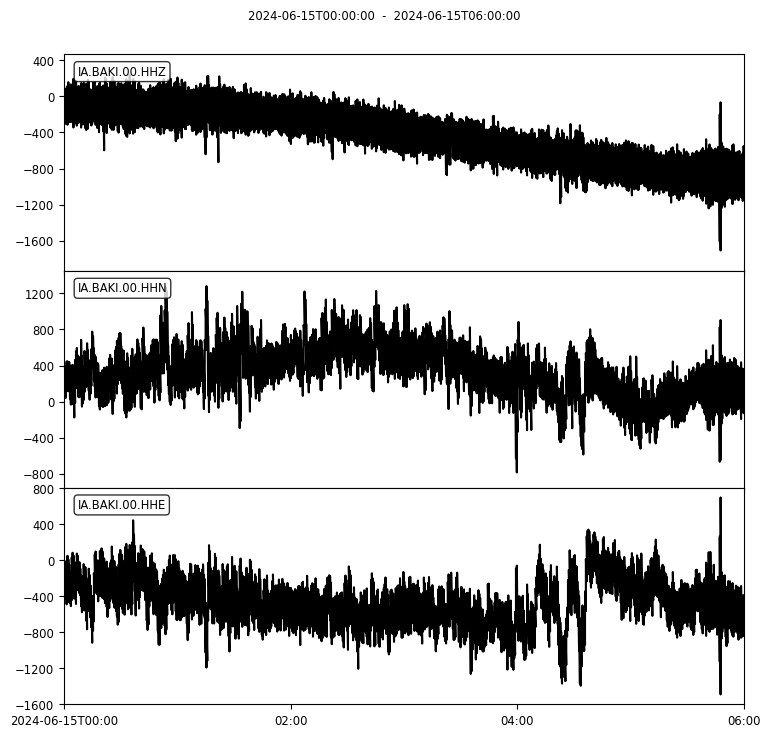

In [37]:
st.plot();

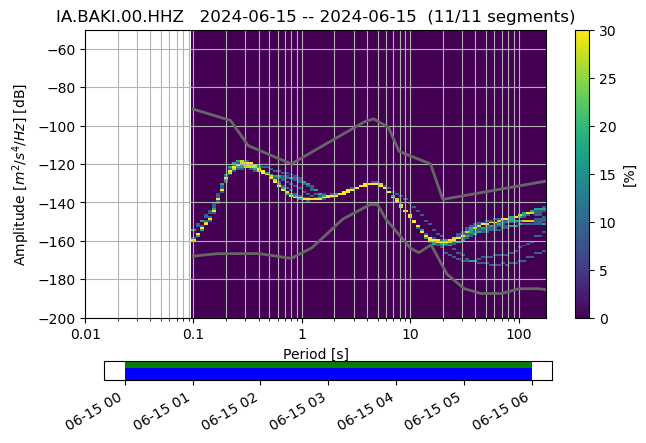

: 

In [ ]:
ppsd.plot();